In [49]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ptitprince as pt
import inspect
import os
from scipy.stats import t
import warnings

In [50]:
parent_directory = os.path.dirname(os.getcwd())
shared_control_ssrt = pd.read_csv(f"{parent_directory}/output/shared_control_metrics_ssrt.csv")
simple_stop_ssrt = pd.read_csv(f"{parent_directory}/output/simple_stop_metrics.csv")
duration_of_inhibition = pd.read_csv(f"{parent_directory}/output/shared_control_metrics_duration_of_inhibition.csv")

In [51]:
shared_control_ssrt.columns = ['subject_id'] + list(shared_control_ssrt.columns[1:])
simple_stop_ssrt.columns = ['subject_id'] + list(simple_stop_ssrt.columns[1:])
merged_df = pd.merge(shared_control_ssrt, simple_stop_ssrt[['subject_id', 'ssrt']], on='subject_id', how='left')
merged_df.rename(columns={'ssrt': 'simple_stop_ssrt'}, inplace=True)

In [52]:
# Remove the last row (the mean row)
merged_df = merged_df.iloc[:-1, :]
duration_of_inhibition = duration_of_inhibition.iloc[:-1, :]

warnings.filterwarnings('ignore') # Ignore warnings

## Figure 2: Non-AI vs AI-Disengaged SSRT

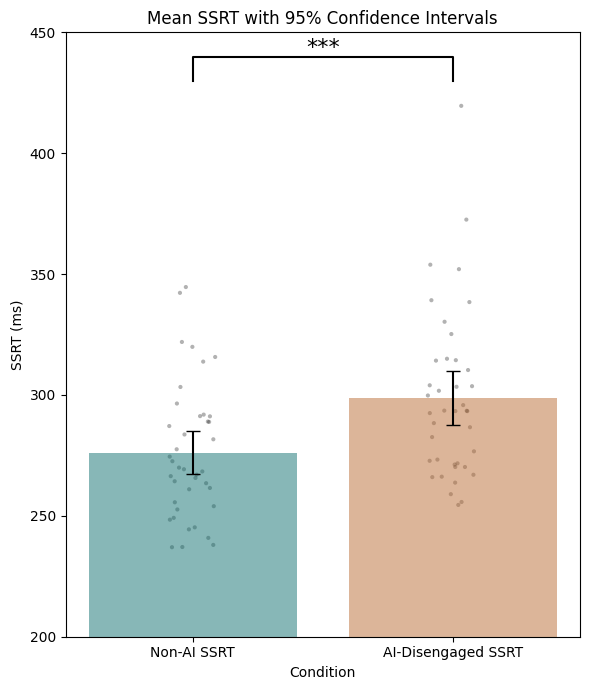

In [53]:
melted_df_ssrt = merged_df.melt(id_vars='subject_id', value_vars=['non_ai', 'ai'],
                            var_name='Condition', value_name='SSRT')
melted_df_ssrt['SSRT'] *= 1000

custom_names = {
    'non_ai': 'Non-AI SSRT',
    'ai': 'AI-Disengaged SSRT'
}

melted_df_ssrt['Condition'] = melted_df_ssrt['Condition'].map(custom_names)

# Calculate means and confidence intervals for the conditions
summary_df = melted_df_ssrt.groupby('Condition').agg(
    Mean=('SSRT', 'mean'),
    SEM=('SSRT', stats.sem)
).reset_index()

# Calculate degrees of freedom for confidence intervals
n = melted_df_ssrt.groupby('Condition').size()
df = n - 1 
confidence_level = 0.95

ci_bounds = stats.t.interval(0.95, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

summary_df = melted_df_ssrt.groupby('Condition').agg(
    Mean=('SSRT', 'mean'),
    SEM=('SSRT', stats.sem)  # Standard error of the mean
).reset_index()

ci_bounds = stats.t.interval(confidence_level, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

desired_order = ['Non-AI SSRT', 'AI-Disengaged SSRT']

summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories=desired_order, ordered=True)
summary_df = summary_df.sort_values('Condition').reset_index()

plt.figure(figsize=(6, 7))

sns.barplot(data=summary_df, x='Condition', y='Mean', palette=["teal", "chocolate"], alpha=0.5)
sns.stripplot(x='Condition', y='SSRT', data=melted_df_ssrt, color='black', alpha=0.3, size=3, jitter=1, zorder=0)

for index, row in summary_df.iterrows():
    plt.errorbar(x=index, y=row['Mean'], 
                 yerr=[[row['Mean'] - row['CI_lower']], [row['CI_upper'] - row['Mean']]], 
                 fmt='none', color='black', capsize=5)
    
plt.plot([0, 0, 1, 1], [430, 440, 440, 430], color='black')
    
# Determine asterisk placement
plt.text(0.5, 441, "***", ha='center', fontsize=16)

# Set the title and labels
plt.title('Mean SSRT with 95% Confidence Intervals')
plt.ylim((200, 450))
plt.xlabel('Condition')
plt.ylabel('SSRT (ms)')

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig(f'{parent_directory}/figures/figure2.png', dpi=300) 
plt.show()

## Figure 3: Non-AI vs AI-Disengaged SSRT by subject

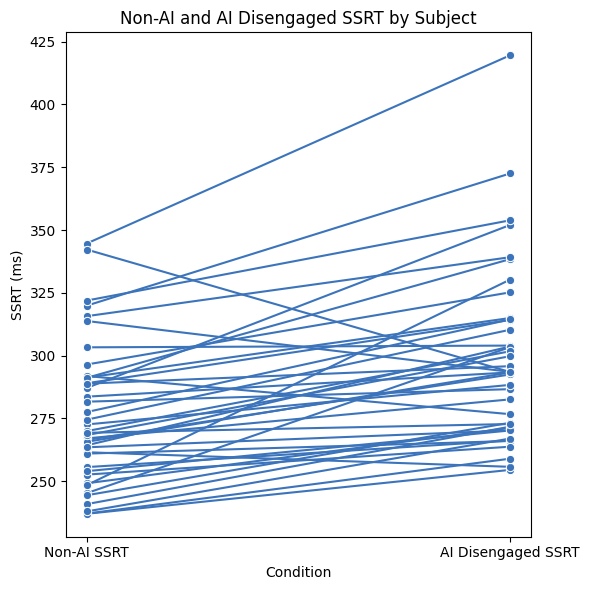

In [54]:
plt.figure(figsize=(6, 6))
ax = sns.lineplot(x='Condition', y='SSRT', data=melted_df_ssrt, hue='subject_id',
                  marker='o', palette=['#3C74BC'] * len(melted_df_ssrt['subject_id'].unique()), legend=False)

tick_positions = np.arange(len(melted_df_ssrt['Condition'].unique()))
ax.set_xticks(tick_positions)
ax.set_xticklabels(['Non-AI SSRT', 'AI Disengaged SSRT'])
ax.set_title('Non-AI and AI Disengaged SSRT by Subject')
ax.set_ylabel('SSRT (ms)')

plt.tight_layout()
plt.savefig(f'{parent_directory}/figures/figure3.png', dpi=300)
plt.show()

## Figure 4: Non-AI vs AI-Disengaged Duration of Inhibition

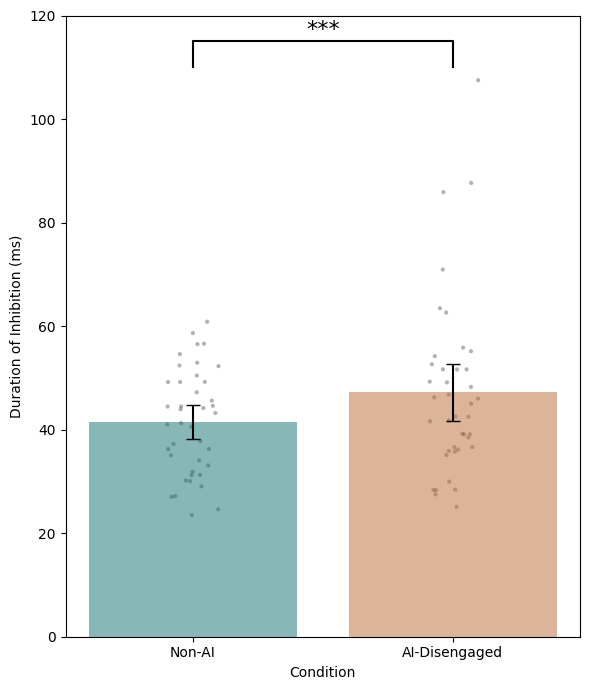

In [55]:
duration_of_inhibition.columns = ['subject_id'] + list(duration_of_inhibition.columns[1:])

melted_df_duration = duration_of_inhibition.melt(id_vars='subject_id', value_vars=['non_ai', 'ai'],
                            var_name='Condition', value_name='Duration of Inhibition')

melted_df_duration['Duration of Inhibition'] *= 1000

custom_names = {
    'non_ai': 'Non-AI',
    'ai': 'AI-Disengaged'
}

melted_df_duration['Condition'] = melted_df_duration['Condition'].map(custom_names)

# Calculate means and confidence intervals for the conditions
summary_df = melted_df_duration.groupby('Condition').agg(
    Mean=('Duration of Inhibition', 'mean'),
    SEM=('Duration of Inhibition', stats.sem)
).reset_index()

n = melted_df_duration.groupby('Condition').size()
df = n - 1

ci_bounds = stats.t.interval(0.95, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

summary_df = melted_df_duration.groupby('Condition').agg(
    Mean=('Duration of Inhibition', 'mean'),
    SEM=('Duration of Inhibition', stats.sem)
).reset_index()

n = melted_df_duration.groupby('Condition').size() 
df = n - 1 
confidence_level = 0.95

ci_bounds = stats.t.interval(confidence_level, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

desired_order = ['Non-AI', 'AI-Disengaged']

summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories=desired_order, ordered=True)
summary_df = summary_df.sort_values('Condition').reset_index()

plt.figure(figsize=(6, 7))

sns.barplot(data=summary_df, x='Condition', y='Mean', palette=["teal", "chocolate"], alpha=0.5)
sns.stripplot(x='Condition', y='Duration of Inhibition', data=melted_df_duration, color='black', alpha=0.3, size=3, jitter=1, zorder=0)

for index, row in summary_df.iterrows():
    plt.errorbar(x=index, y=row['Mean'], 
                 yerr=[[row['Mean'] - row['CI_lower']], [row['CI_upper'] - row['Mean']]], 
                 fmt='none', color='black', capsize=5)
    
plt.plot([0, 0, 1, 1], [110, 115, 115, 110], color='black')

plt.text(0.5, 116, "***", ha='center', fontsize=16)
plt.ylim((0, 120))
plt.xlabel('Condition')
plt.ylabel('Duration of Inhibition (ms)')

plt.tight_layout()
plt.savefig(f'{parent_directory}/figures/figure4.png', dpi=300) 
plt.show()